In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
import cv2 as cv


2024-02-23 21:43:44.256183: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 21:43:44.256232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 21:43:44.260316: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# python librairies installation
!pip install split-folders matplotlib opencv-python spicy
import splitfolders

In [3]:
from pathlib import Path
dataset_Dir = '/kaggle/input/cottonweedid15/CottonWeedID15'
#dataset_Dir = Path(' /kaggle/input/cottonweedid15/CottonWeedID15/')
print(os.listdir (dataset_Dir))

num_classes = len(os.listdir (dataset_Dir))
print (num_classes)


['Nutsedge', 'Sicklepod', 'Morningglory', 'Ragweed', 'PalmerAmaranth', 'Waterhemp', 'Crabgrass', 'Swinecress', 'Prickly Sida', 'Carpetweeds', 'SpottedSpurge', 'SpurredAnoda', 'Eclipta', 'Goosegrass', 'Purslane']
15


In [4]:
redataset_Dir ='/kaggle/working/Weeddata_Split/'
ratio_list = [0.65, 0.2, 0.15]

# split data in a new folder named data-split
splitfolders.ratio (dataset_Dir, output=redataset_Dir, seed=1337, ratio=ratio_list, group_prefix=None, move=False)

Copying files: 5187 files [02:24, 35.88 files/s] 


In [5]:
# # Define the image size and normalization parameters
# IMAGE_SIZE = (512, 512)
# COLOR_MODE = 'rgb'
# BATCH_SIZE = 32
# NUM_CLASSES = 15  # Define the number of classes for your dataset

# def rescale_img(img):
#     img = img.astype(np.float32) / 255.0
#     img = (img - 0.5) * 2
#     return img

# # Define a function to load data and create generators
# def create_data_generators(redataset_Dir):
#     # Define the paths to the directories for training, validation, and testing data
#     train_data_dir = os.path.join(redataset_Dir, 'train')
#     valid_data_dir = os.path.join(redataset_Dir, 'val')
#     test_data_dir = os.path.join(redataset_Dir, 'test')

#     # Define the data augmentation parameters for training data
#     train_datagen = ImageDataGenerator(
#         #rescale=1./255,#((1./127.5)-1),  # Rescale pixel values to [-1, 1]
#         rotation_range=180,    # Random rotation in the range [-180, +180] degrees
#         horizontal_flip=True,  # Random horizontal flipping
#     )

#     # Define validation data generator (only rescale, no augmentation)
#     valid_datagen = ImageDataGenerator(
#         rescale = 255./255 #1./127.5 - 1 # Rescale pixel values to [-1, 1]
#     )

#    # Define test data generator (only rescale, no augmentation)
#     test_datagen = ImageDataGenerator( rescale = 255./255 )

#     # Load training data with augmentation and resizing
#     train_generator = train_datagen.flow_from_directory(
#         train_data_dir,
#         target_size=IMAGE_SIZE,  # Resize images to 512 × 512 pixels
#         color_mode=COLOR_MODE,
#         batch_size=BATCH_SIZE,
#         class_mode='categorical',
#         shuffle=True
#     )

#     valid_generator = valid_datagen.flow_from_directory(
#         valid_data_dir,
#         target_size=IMAGE_SIZE,  # Resize images to 512 × 512 pixels
#         color_mode=COLOR_MODE,
#         batch_size=BATCH_SIZE,
#         class_mode='categorical',
#         shuffle=False
#     )

#     test_generator = test_datagen.flow_from_directory(
#         test_data_dir,
#         target_size=IMAGE_SIZE,  # Resize images to 512 × 512 pixels
#         color_mode=COLOR_MODE,
#         batch_size=BATCH_SIZE,
#         class_mode='categorical',
#         shuffle=False
#     )

#     return train_generator, valid_generator, test_generator


In [6]:
# Define the image size and normalization parameters
IMAGE_SIZE = (512, 512)
COLOR_MODE = 'rgb'
BATCH_SIZE = 12
NUM_CLASSES = 15  # Define the number of classes for your dataset


# Define a function to load data and create generators
def create_data_generators(redataset_Dir):
    # Define the paths to the directories for training, validation, and testing data
    # train_data_dir = os.path.join(redataset_Dir, 'train')
    # valid_data_dir = os.path.join(redataset_Dir, 'val')
    # test_data_dir = os.path.join(redataset_Dir, 'test')


    # Create the train, validation, and test datasets using tf.keras.utils.image_dataset_from_directory
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        os.path.join(redataset_Dir, 'train'),
        label_mode='categorical',
        image_size=IMAGE_SIZE,
        color_mode=COLOR_MODE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )

    valid_dataset = tf.keras.utils.image_dataset_from_directory(
        os.path.join(redataset_Dir, 'val'),
        label_mode='categorical',
        image_size=IMAGE_SIZE,
        color_mode=COLOR_MODE,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        os.path.join(redataset_Dir, 'test'),
        label_mode='categorical',
        image_size=IMAGE_SIZE,
        color_mode=COLOR_MODE,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    return train_dataset, valid_dataset, test_dataset


In [7]:
train_dataset, valid_dataset, test_dataset = create_data_generators(redataset_Dir)

Found 3364 files belonging to 15 classes.
Found 1031 files belonging to 15 classes.
Found 792 files belonging to 15 classes.


In [8]:
image_batch, label_batch = next(iter(train_dataset))
i = 0
out = image_batch[i]
#print(image_batch[i])
print(np.max(image_batch[i]))
print(np.min(image_batch[i]))


255.0
0.35370636


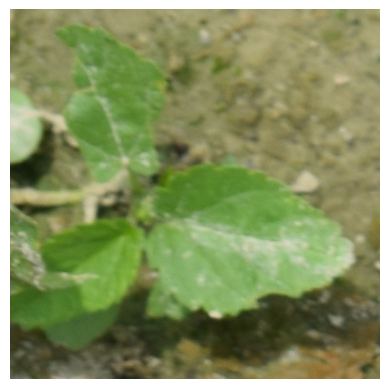

In [9]:
# prompt: show the image

import matplotlib.pyplot as plt

# Get the first image from the training dataset
image_batch, label_batch = next(iter(train_dataset))
first_image = image_batch[0]

# Show the image
plt.imshow(first_image.numpy().astype("uint8"))
plt.axis('off')
plt.show()


In [10]:
# # prompt: show the image from train_generator'

# import matplotlib.pyplot as plt

# class_names = train_dataset.class_names

# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     #plt.title(class_names[labels[i]])
#     plt.axis("off")()


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
rescale_Func = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Create the train, validation, and test generators
normalized_train_dataset = train_dataset.map(lambda x, y: (rescale_Func(x), y))
normalized_valid_dataset = valid_dataset.map(lambda x, y: (rescale_Func(x), y))
normalized_test_dataset = test_dataset.map(lambda x, y: (rescale_Func(x), y))

image_batch, labels_batch = next(iter(normalized_train_dataset))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

-1.0 1.0


In [13]:
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(180)
])

# Apply data augmentation to train_dataset
normalized_train_dataset = normalized_train_dataset.map(lambda x, y: (data_augmentation(x), y))

In [14]:
# Load pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))

# Freeze convolutional base
for layer in base_model.layers:
    layer.trainable = True

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(4096, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create new model
model = Model(inputs=base_model.input, outputs=predictions)

# Define SGD optimizer with momentum
sgd = SGD(learning_rate=0.001, momentum=0.9)

# Define learning rate schedule function
def lr_scheduler(epoch):
    initial_lr = 0.001
    decay_factor = 0.1
    epochs_drop = 7
    lr = initial_lr * np.power(decay_factor, np.floor((1 + epoch) / epochs_drop))
    return lr

# Compile the model with SGD optimizer and learning rate scheduler
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Define learning rate scheduler callback
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)



In [15]:
# Train the model
history = model.fit(
    normalized_train_dataset,
    epochs=50,
    validation_data=normalized_valid_dataset,
    callbacks=[lr_scheduler_callback],
    #workers=tf.data.experimental.AUTOTUNE
)

Epoch 1/50


I0000 00:00:1708724895.873463     531 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1708724895.965151     531 hlo_rematerialization.cc:2946] Can't reduce memory use below 5.51GiB (5914773402 bytes) by rematerialization; only reduced to 6.00GiB (6442450960 bytes), down from 6.00GiB (6442450960 bytes) originally


281/281 [==============================] - 394s 1s/step - loss: 2.7235 - accuracy: 0.1938 - val_loss: 2.4222 - val_accuracy: 0.2144 - lr: 0.0010
Epoch 2/50
281/281 [==============================] - 308s 1s/step - loss: 2.3017 - accuracy: 0.2375 - val_loss: 2.1502 - val_accuracy: 0.2813 - lr: 0.0010
Epoch 3/50
281/281 [==============================] - 311s 1s/step - loss: 2.0532 - accuracy: 0.3255 - val_loss: 1.8040 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 4/50
281/281 [==============================] - 311s 1s/step - loss: 1.7118 - accuracy: 0.4471 - val_loss: 1.7673 - val_accuracy: 0.4394 - lr: 0.0010
Epoch 5/50
281/281 [==============================] - 312s 1s/step - loss: 1.2923 - accuracy: 0.5883 - val_loss: 0.8980 - val_accuracy: 0.7168 - lr: 0.0010
Epoch 6/50
281/281 [==============================] - 312s 1s/step - loss: 0.6813 - accuracy: 0.7738 - val_loss: 0.7506 - val_accuracy: 0.7818 - lr: 0.0010
Epoch 7/50
281/281 [==============================] - 312s 1s/step - loss: 

In [17]:
# Load the test data
test_loss, test_accuracy = model.evaluate(normalized_test_dataset)

# Print training accuracy, validation accuracy, and test accuracy
print("Training Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])
print("Test Accuracy:", test_accuracy)

# Save the model parameters using the native Keras format
model.save('vgg16_custom_model.keras')


66/66 [==============================] - 21s 322ms/step - loss: 0.1749 - accuracy: 0.9444
Training Accuracy: 0.9720571041107178
Validation Accuracy: 0.931134819984436
Test Accuracy: 0.9444444179534912
